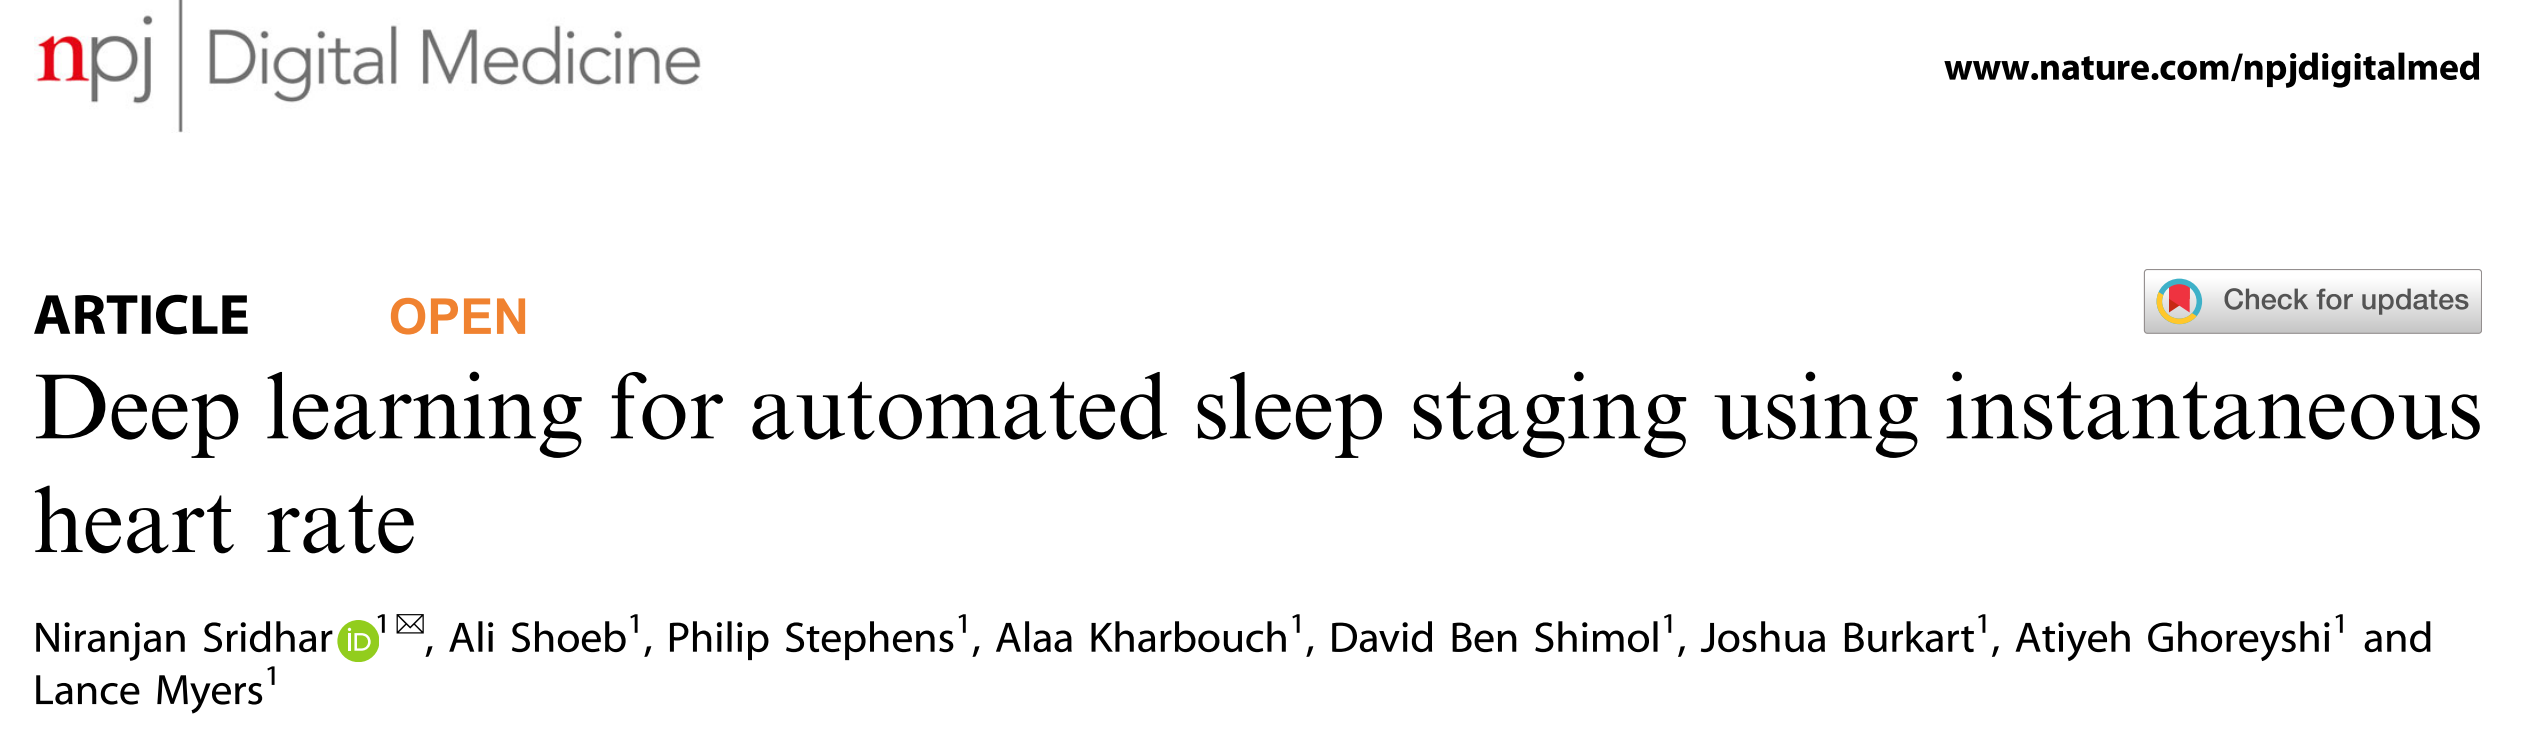

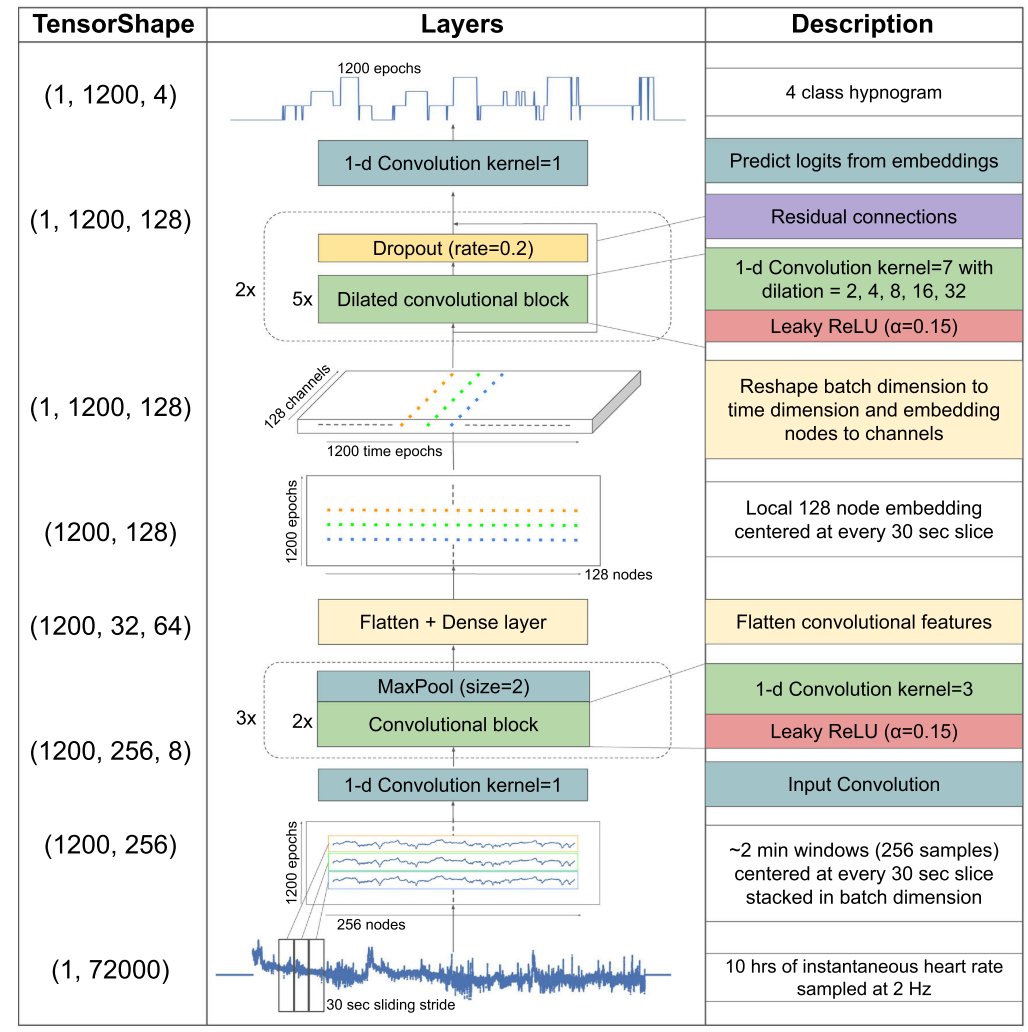

In [1]:
from IPython.display import Image
display(Image(filename='/home/kkotzen/research/PPG_sleepstaging_orion2 /notebooks/Wet-Lab/Sridhar.png'))
display(Image(filename='/home/kkotzen/research/PPG_sleepstaging_orion2 /notebooks/Wet-Lab/Network.png', width=600))


# Step 1: Extract IHR Signal from ECG Annotations

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, interpolate
import copy
import os 
import pandas as pd
os.chdir('/home/kkotzen/research/PPG_sleepstaging_orion2 /')
from pathlib import Path
from src.parsing.MESAParser import MESAParser
from utils.figures import *

# What is the IHR Signal

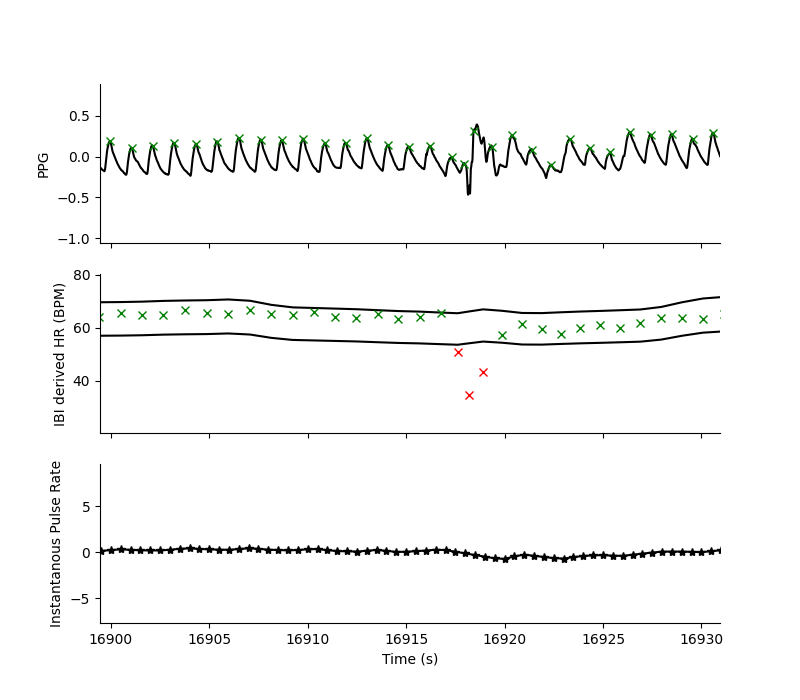

In [3]:
Image(filename='/home/kkotzen/research/PPG_sleepstaging_orion2 /notebooks/Wet-Lab/ihr_from_ppg.png') 

In [4]:
%matplotlib widget
import sys
import os

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.model_selection import train_test_split

os.chdir('/home/kkotzen/research/PPG_sleepstaging_orion2 /')
from src.models.model_utils import plot_hypnogram
from src.parsing.MESAParser import MESAParser

def _time_series_subsequences(ts, window, hop=1):
        assert len(ts.shape) == 1
        shape = (int(int(ts.size - window) / hop + 1), window)
        strides = ts.strides[0] * hop, ts.strides[0]
        return np.lib.stride_tricks.as_strided(ts, shape=shape, strides=strides)

def _subsequenced_padded(X, win_len, hop):
    assert X.shape[0] % hop == 0
    padding = int(win_len / 2 - hop / 2)
    X__ = np.zeros((X.shape[0] + 2 * padding))
    X__[padding:-padding] = X
    X_ = _time_series_subsequences(X__.flatten(), win_len, hop)
    return X_

def comp_google_ihr_2hz(beats, fs, quality):
    
    quality = np.convolve(quality, np.ones(5)/5, "same")
    last_good_epoch = np.where(quality>0.9)[0][-1]
    beats = beats[beats < last_good_epoch*30*fs]
    
    beats = beats / fs
    ibi = np.diff(beats)
    beats = beats[:-1] + (beats[1:] - beats[:-1]) / 2
    
    upper = np.percentile(ibi, 95)
    lower = np.percentile(ibi, 5)

    ibi_filt_idx = np.where((ibi < upper) & (ibi > lower))
    ibi = ibi[ibi_filt_idx]
    beats = beats[ibi_filt_idx]
    
    ihr = (1 / ibi)
    
    x_2hz = np.arange(0, beats[-1], 1 / 2)
    ihr_2hz = np.interp(x_2hz, beats, ihr)

    ihr_2hz = (ihr_2hz - np.mean(ihr_2hz)) / np.std(ihr_2hz)

    return ihr_2hz


def comp_google_ihr(patient, dl):
    beats = dl.load_annotation(patient, signal='Pleth', annotator='Aboy', annotation='Peaks') 
    quality = dl.load_quality(patient, signal='Pleth')
    return comp_google_ihr_2hz(beats, dl.ppg_fs, quality)


def load_XY(dl, patients):

    ihr_fs = 2
    ihr_resampled_fs = 2
    epoch_len = 30*ihr_resampled_fs
    total_time_steps = 1200
    total_len = int(epoch_len*1200)
    batch_size = len(patients)
    sleep_string_encoding = {0:'zero', 1:'one', 2:'two', 3:'three', 4:'four', 5: "five"}
    sleep_encoding = {'zero': 0, 'one': 1, 'two': 2, 'three': 2, 'four': 3, 'five': 9}

    X = np.zeros((batch_size, total_time_steps, 256))
    Y = np.zeros((batch_size, total_time_steps))

    for i, patient in tqdm(enumerate(patients)):
        patient = str(patient).zfill(4)
                
        sleep = dl.load_sleep(patient)
        sleep[sleep > 5] = 0
        sleep = [sleep_string_encoding[s] for s in sleep]
        sleep = np.array([sleep_encoding[s] for s in sleep])
        sleep[sleep > 9] = 0

        L = sleep.shape[0]
        if L > total_time_steps:
            L = total_time_steps
        Y[i, 0:L] = sleep[0:L]
        
        
        ihr = comp_google_ihr(patient, dl)
        L = ihr.shape[0]
        if L > total_len:
            L = total_len
        elif L % epoch_len !=0:
            L = int(L/epoch_len)*epoch_len
        ihr_strided = _subsequenced_padded(ihr[0:L], 256, epoch_len)
        L = ihr_strided.shape[0]
#         print(ihr_strided.shape, L)
        X[i,0:L] = ihr_strided
        
        

    return X, Y

def calc_class_sample_weights(ty, weight_adjustment=[]):
    if len(ty.shape) == 1:
        y = ty.reshape(ty.shape[0])
    else:
        y = ty.reshape(ty.shape[0] * ty.shape[1])
    classes = np.unique(y)

    if len(weight_adjustment) > 0 and len(weight_adjustment) != len(classes):
        raise ValueError("The weight adjustment variable needs to have as many values as there are classes")
    elif len(weight_adjustment) == 0:
        weight_adjustment = np.ones(len(classes))

    class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y) * weight_adjustment
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}
    sample_weights = np.vectorize(class_weights.get)(ty)
    return class_weights, sample_weights

def duplicate(x):
    return np.array([[x_]*2 for x_ in x]).flatten()

def hold_line(t, x):
    t = [i for i in t]
    x = [i for i in x]
    
    if len(t) - len(x) == 0:
            t.append(t[-1]+t[-1]-t[-2])
    if len(t)-len(x) != 1:
            raise ValueError()
            
    t_ = duplicate(t)[1:-1]
    x_ = duplicate(x)
    return t_, x_

In [5]:
dl = MESAParser()
train_patients, test_patients= dl.get_train_test_patients_from_file()
patient = train_patients[0]
ihr = comp_google_ihr(patient, dl)
sleep = dl.load_sleep(patient)

plt.close('all')
plt.subplot(2,1,1)
plt.plot(sleep)
plt.subplot(2,1,2)
plt.plot(ihr)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [6]:
dl = MESAParser()
# train_patients, validate_patients = train_test_split(train_patients, test_size = len(test_patients), random_state=6668)
# train_X, train_Y = load_XY(dl, train_patients[0:600])
# validate_X, validate_Y = load_XY(dl, validate_patients[0:100])
# test_X, test_Y = load_XY(dl, test_patients[0:100])

# np.savez("/home/kkotzen/research/PPG_sleepstaging_orion2 /notebooks/Wet-Lab/data/lab_train.npz", train_X=train_X, train_Y=train_Y)
# np.savez("/home/kkotzen/research/PPG_sleepstaging_orion2 /notebooks/Wet-Lab/data/lab_validate.npz", validate_X=validate_X, validate_Y=validate_Y)
# np.savez("/home/kkotzen/research/PPG_sleepstaging_orion2 /notebooks/Wet-Lab/data/lab_test.npz", test_X=test_X, test_Y=test_Y)

In [7]:
train = np.load('/home/kkotzen/research/PPG_sleepstaging_orion2 /notebooks/Wet-Lab/data/lab_train.npz')
train_X, train_Y = train['train_X'], train['train_Y']
validate = np.load('/home/kkotzen/research/PPG_sleepstaging_orion2 /notebooks/Wet-Lab/data/lab_validate.npz')
validate_X, validate_Y = validate['validate_X'], validate['validate_Y']
test = np.load('/home/kkotzen/research/PPG_sleepstaging_orion2 /notebooks/Wet-Lab/data/lab_test.npz')
test_X, test_Y = test['test_X'], test['test_Y']
train_Y[train_Y==9] = 0
validate_Y[validate_Y==9] = 0
test_Y[test_Y==9] = 0

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1],train_X.shape[2],1)
validate_X = validate_X.reshape(validate_X.shape[0], validate_X.shape[1],validate_X.shape[2],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1],test_X.shape[2],1)

print(train_X.shape, train_Y.shape)
print(validate_X.shape, validate_Y.shape)
print(test_X.shape, test_Y.shape)



(600, 1200, 256, 1) (600, 1200)
(100, 1200, 256, 1) (100, 1200)
(100, 1200, 256, 1) (100, 1200)


# Step 2: Build the Model

In [8]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], enable=True)

from tensorflow.python.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Conv1D, GlobalAveragePooling1D, AveragePooling1D, MaxPool1D, Flatten, Dense, \
    Reshape, Dropout, TimeDistributed, Add, LSTM, GRU, Bidirectional
from tensorflow.python.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.utils import class_weight

import tensorflow_addons as tfa 

class CohenKappa2D(tf.keras.metrics.Metric):

    def __init__(self, name='kappa', num_classes=4, sparse_labels=True, batch_size=2, **kwargs):
        super(CohenKappa2D, self).__init__(name=name, **kwargs)
        self.batch_size = batch_size
        self.metric = tfa.metrics.CohenKappa(num_classes=num_classes, sparse_labels=sparse_labels)

    def update_state(self, y_true, y_pred, sample_weight):

        true_shape = tf.shape(y_true)
        pred_shape = tf.shape(y_pred)

        y_true = tf.reshape(y_true, [true_shape[0]*true_shape[1]])

        if len(pred_shape)==3:
            y_pred = tf.reshape(y_pred, [pred_shape[0] * pred_shape[1], pred_shape[2]])
        if len(y_pred.shape)==4:
            y_pred = tf.reshape(y_pred, [pred_shape[0] * pred_shape[1] * pred_shape[2],pred_shape[3]])

        if not sample_weight is None:
            weight_shape = tf.shape(sample_weight)
            sample_weight = tf.reshape(sample_weight, [weight_shape[0]*weight_shape[1]])

        self.metric.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.metric.reset_state()

    def result(self):
        return self.metric.result()


    
def dilated_residual_convolution(X_in, kernel, dilations, dropout, name="", l1=0):
    X = X_in
    for i, dilation in enumerate(dilations):
        X = TimeDistributed(
            Conv1D(X_in.shape[-1], kernel_size=kernel, dilation_rate=dilation, padding='same',
                   kernel_regularizer=tf.keras.regularizers.l1(l=l1)),
            name=f"{name}_Conv{i}")(X)
        X = TimeDistributed(LeakyReLU(alpha=0.15))(X)
    X = Add(name=f"{name}_Addition")([X, X_in])
    if dropout > 0:
        X = TimeDistributed(Dropout(dropout), name=f"{name}_Dropout")(X)
    return X


def residual_convolution(X_in, kernel, filt, n_convs, name=None, l1=0):
    X = X_in
    # Residual needs 1x1 CNN
    X_residual = TimeDistributed(Conv1D(filt, 1, activation='relu', padding='same'), name=f"{name}_residual_1x1Conv")(X)
    X_residual = TimeDistributed(MaxPool1D(2, strides=2), name=f"{name}_residual_Maxpool")(X_residual)

    # Convolutions and max pooling
    for i in range(n_convs):
        X = TimeDistributed(Conv1D(filt, kernel, kernel_regularizer=tf.keras.regularizers.l1(l=l1), padding='same'),
                            name=f"{name}_Conv{i}")(X)
        X = LeakyReLU(alpha=0.15)(X)

    # Bring in the residual
    X = TimeDistributed(MaxPool1D(2, strides=2), name=f"{name}_Maxpool")(X)
    X = Add(name=f"{name}_residual_Add")([X, X_residual])

    return X


def convolution(X_in, kernel, filt, n_convs=1, name=None, l1=0):
    X = X_in
    for i in range(n_convs):
        X = TimeDistributed(Conv1D(filt, kernel, padding='same', kernel_regularizer=tf.keras.regularizers.l1(l=l1)),
                            name=f"{name}_Conv{i}")(X)
        X = LeakyReLU(alpha=0.15)(X)
    X = TimeDistributed(MaxPool1D(2, strides=2), name=f"{name}_maxpool")(X)
    return X


def google_model(shape, params):
    print("Building Model", end="")
    inputs = Input(shape=(shape[1], shape[2], 1))
    X = TimeDistributed(Conv1D(params['input_convs'], 1, padding='same', kernel_regularizer =tf.keras.regularizers.l1(l=params['l1'])), name="InputConv")(inputs)

    X = residual_convolution(X, kernel=params['conv_kernel'], filt=params['conv_filters_base'], n_convs=2, name="ConvBlock1", l1=params['l1'])
    X = residual_convolution(X, kernel=params['conv_kernel'], filt=params['conv_filters_base']*2, n_convs=2, name="ConvBlock2",l1=params['l1'])
    X = residual_convolution(X, kernel=params['conv_kernel'], filt=params['conv_filters_base']*4, n_convs=2, name="ConvBlock3",l1=params['l1'])

    X = TimeDistributed(Flatten(), name=f"Flatten")(X)
    # X = TimeDistributed(Dropout(params['dropout']), name=f"DropoutD1")(X)
    X = TimeDistributed(Dense(units=params['dense1']), name=f"Dense1")(X)
    X = TimeDistributed(LeakyReLU(alpha=0.15))(X)

    if params['use_dense2']:
        X = TimeDistributed(Dropout(params['dropout']), name=f"DropoutD2")(X)
        X = TimeDistributed(Dense(units=params['dense2']), name=f"Dense2")(X)
        X = TimeDistributed(LeakyReLU(alpha=0.15))(X)

    X = Reshape(target_shape=(1, X.shape[1], X.shape[2]))(X)

    X = dilated_residual_convolution(X, kernel=int(params['dilated_kernel']), dilations=[2, 4, 8, 16, 32], dropout=params['dropout'], l1=params['l1'], name="Dilated1")
    if params['use_dilated_2']:
        X = dilated_residual_convolution(X, kernel=int(params['dilated_kernel']), dilations=[2, 4, 8, 16, 32], dropout=params['dropout'], l1=params['l1'], name="Dilated2")
    if params['use_dilated_3']:
        X = dilated_residual_convolution(X, kernel=int(params['dilated_kernel']), dilations=[2, 4, 8, 16, 32], dropout=params['dropout'], l1=params['l1'], name="Dilated3")

    out = TimeDistributed(Conv1D(4, 1, activation='softmax'))(X)

    model = Model(inputs=inputs, outputs=out)

    kappa = CohenKappa2D(num_classes=4, sparse_labels=True)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=params['learning_rate'],
        decay_steps=2300*3,
        decay_rate=0.9)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy', kappa ],
                  sample_weight_mode="temporal")
    print("Model Compiled")
    return model


In [9]:
params = {}
params['memory_time_steps'] = 1200
params['overlap'] = 0
params['learning_rate'] = 0.0001
params['epochs'] = 80
params['batch_size'] = 1
params['verbose'] = 1
params['es_mc'] = True
params['es_mc_metric'] = 'kappa'

params['evaluation_set'] = 'test'
params['dropout'] = 0.45

params['weight_wake'] = 1.0
params['weight_light'] = 1.0
params['weight_deep'] = 4.0
params['weight_rem'] = 1.0

#Google Model Params
params['l1'] = 0
params['input_convs'] = 8
params['dilated_kernel'] = 7
params['use_dilated_2'] = True
params['use_dilated_3'] = False
params['conv_kernel'] = 3
params['conv_filters_base'] = 16
params['dense1'] = 128
params['use_dense2'] = False
params['dense2'] = 64


model = google_model((1,1200,256,1), params)
model.summary()

Building ModelModel Compiled
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1200, 256, 1 0                                            
__________________________________________________________________________________________________
InputConv (TimeDistributed)     (None, 1200, 256, 8) 16          input_1[0][0]                    
__________________________________________________________________________________________________
ConvBlock1_Conv0 (TimeDistribut (None, 1200, 256, 16 400         InputConv[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1200, 256, 16 0           ConvBlock1_Conv0[0][0]           
_________________________________________________________________

# Step 3: Train Model

In [10]:
def calc_class_sample_weights(ty, weight_adjustment=[]):
    if len(ty.shape) == 1:
        y = ty.reshape(ty.shape[0])
    else:
        y = ty.reshape(ty.shape[0] * ty.shape[1])
    classes = np.unique(y)
    
    print(y.shape)
    if len(weight_adjustment) != len(classes):
        raise ValueError("The weight adjustment variable needs to have as many values as there are classes")
    elif len(weight_adjustment) == 0:
        weight_adjustment = np.ones(len(classes))

    class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y) * weight_adjustment
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}
    return class_weights


class_weights = calc_class_sample_weights(train_Y, [1,1,2,1])
print(class_weights)
train_weights = (np.vectorize(class_weights.get)(train_Y)) 
validate_weights = (np.vectorize(class_weights.get)(validate_Y)) 
history = model.fit(x=train_X,
                    y=train_Y,
                    sample_weight=train_weights,
                    validation_data=(validate_X, validate_Y,validate_weights),
                    epochs=20,
                    batch_size=2,
                    shuffle=True)

(720000,)
{0: 0.6099668584673567, 1: 3.151591553734636, 2: 1.2373302537558128, 3: 2.3425604185374613}
Epoch 1/20
300/300 [==============================] - 18s 32ms/step - loss: 1.2888 - accuracy: 0.5336 - kappa: 0.3350 - val_loss: 1.2256 - val_accuracy: 0.5596 - val_kappa: 0.3884
Epoch 2/20
300/300 [==============================] - 9s 29ms/step - loss: 1.1232 - accuracy: 0.5735 - kappa: 0.4317 - val_loss: 1.1223 - val_accuracy: 0.5879 - val_kappa: 0.4520
Epoch 3/20
300/300 [==============================] - 8s 28ms/step - loss: 1.0550 - accuracy: 0.5808 - kappa: 0.4782 - val_loss: 1.0465 - val_accuracy: 0.5930 - val_kappa: 0.5226
Epoch 4/20
300/300 [==============================] - 9s 30ms/step - loss: 0.9849 - accuracy: 0.5909 - kappa: 0.5234 - val_loss: 1.0333 - val_accuracy: 0.5933 - val_kappa: 0.5291
Epoch 5/20
300/300 [==============================] - 9s 29ms/step - loss: 0.9572 - accuracy: 0.5927 - kappa: 0.5389 - val_loss: 0.9955 - val_accuracy: 0.5996 - val_kappa: 0.5463
Ep

In [13]:
plt.close('all')
plt.plot(history.history)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

TypeError: float() argument must be a string or a number, not 'dict'

# Step 4: Test Model on Test Set

In [14]:
from src.models.model_utils import plot_investigative_hypnogram

test_probs = model.predict(test_X)
test_probs = test_probs.reshape(test_probs.shape[0], test_probs.shape[2], test_probs.shape[3])
test_preds = np.argmax(test_probs, axis=2)

patient_i = 15
label = test_Y[patient_i]
prediction = test_preds[patient_i]
probability = test_probs[patient_i]
signal_quality = dl.load_quality(test_patients[patient_i], signal='Pleth')


In [15]:
f = plot_investigative_hypnogram(label, prediction, probability, signal_quality, patient, "", {0:"Wake", 1:"Light", 2:"Deep", 3:"REM"}, size=(40,15))
plt.savefig('/home/kkotzen/research/PPG_sleepstaging_orion2 /notebooks/Wet-Lab/Hypnpgram.png')
plt.close('all')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

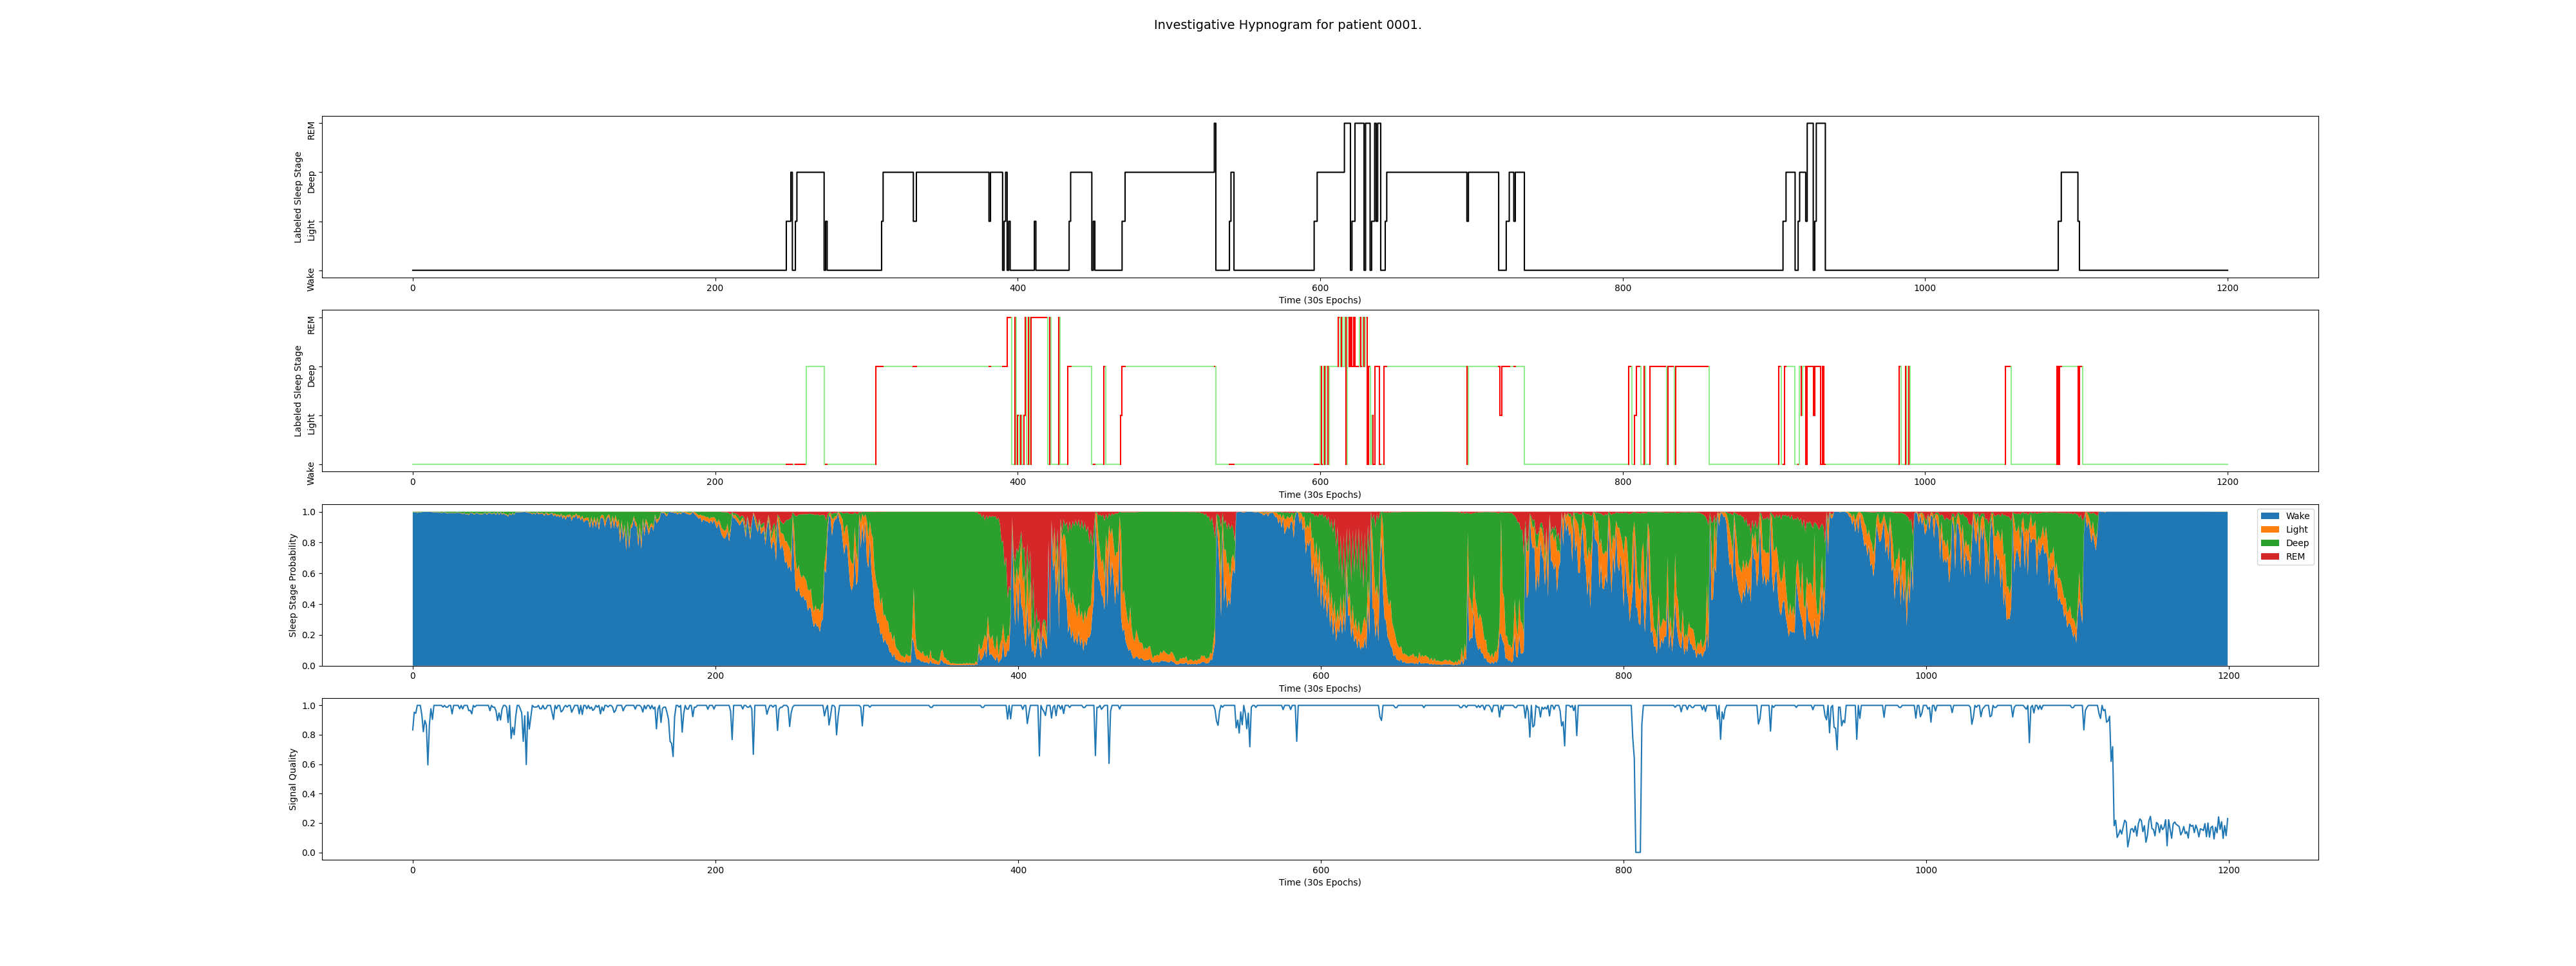

In [16]:
display(Image(filename='/home/kkotzen/research/PPG_sleepstaging_orion2 /notebooks/Wet-Lab/Hypnpgram.png'))

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score


def calculate_performance_metrics(labels, predictions, classes, plot_confusion=True):
    # Confusion Matrix
    conf = confusion_matrix(labels, predictions, labels=None, sample_weight=None, normalize=None)
    conf_norm = confusion_matrix(labels, predictions, labels=None, sample_weight=None, normalize='true')
    conf_matrix_dict = {'matrix': conf, 'labels': list(classes)}
    if plot_confusion:
        conf_matrix_figure = make_confusion_matrix(y_reference=labels, y_predicted=predictions,
                                                   categories=classes)
    else:
        conf_matrix_figure = None

    # Evaluation Metrics
    cr = pd.DataFrame(classification_report(labels, predictions, target_names=classes, output_dict=True)).T
    acc = accuracy_score(labels, predictions)
    kappa = cohen_kappa_score(labels, predictions)

    conf = pd.DataFrame(conf, columns=classes, index=classes)
    conf_norm = pd.DataFrame(conf_norm, columns=classes, index=classes)
    report = conf
    report = f"{report}\n{conf_norm}"
    report = f"{report}\nClassification Report"
    report = f"{report}\n{cr}"
    report = f"{report}\nAccuracy:\t{acc}\nKappa:\t\t {kappa}\nWeighted F1:\t{cr['f1-score']['macro avg']}"

    metrics = {'Weighted F1': cr['f1-score']['weighted avg'], 'Accuracy:': acc,
               'Kappa:': kappa, 'Macro F1': cr['f1-score']['macro avg']}

    return report, metrics, conf_matrix_dict, conf_matrix_figure

In [18]:
print(test_Y.shape, test_preds.shape)
metrics = calculate_performance_metrics(test_Y.flatten(), test_preds.flatten(), ['Wake', 'Light', 'Deep', 'REM'])

(100, 1200) (100, 1200)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …